# Redo Marks fitness pred

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights


Loaded 29 KD vectors


C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


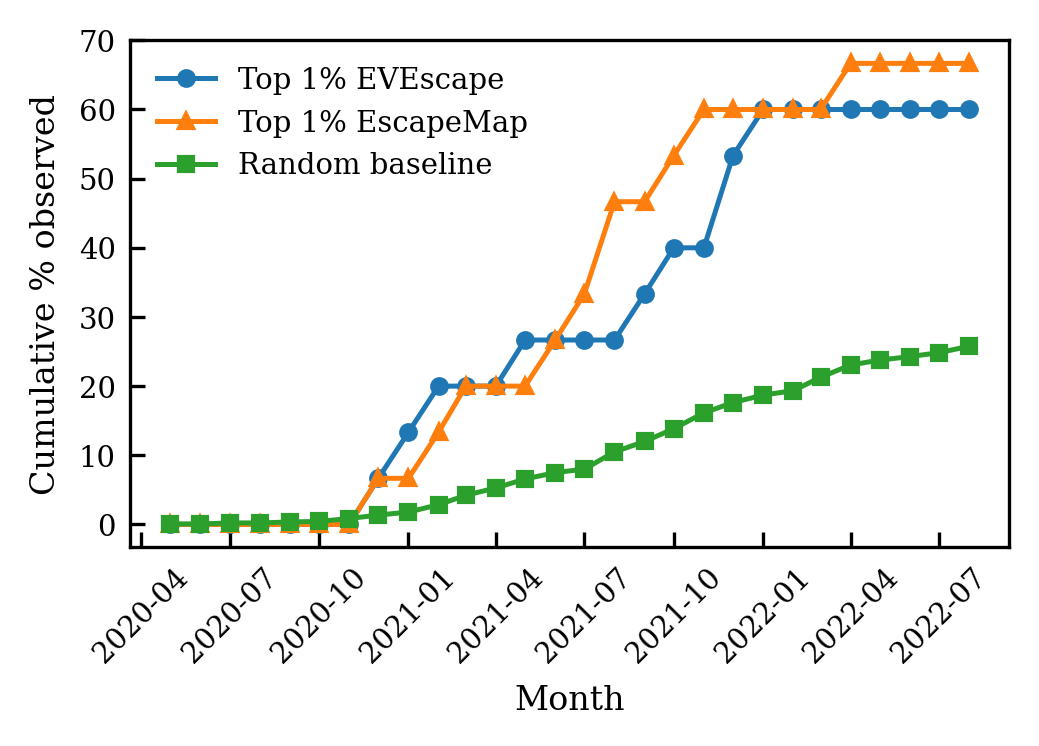

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df = df[(df['i'] >= 349) & (df['i'] <= 526)].copy()

# attach EscapeMap scores (aligned by row order)
df_em4 = pd.read_csv("scores_sigmoid_diff_4ab.csv")
df_em  = pd.read_csv("scores_sigmoid_diff.csv")

col_em4 = "score" if "score" in df_em4.columns else "scores"
col_em  = "score" if "score" in df_em.columns else "scores"

df["escapemap_4ab"] = df_em4[col_em4].values
df["escapemap"]     = df_em[col_em].values

# --- Top 10% by each model ---
th=99
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)
thr_em4 = np.nanpercentile(df["escapemap_4ab"], th)

top_eve = df[df["evescape"] >= thr_eve].copy()
top_em  = df[df["escapemap"] >= thr_em].copy()
top_em4 = df[df["escapemap_4ab"] >= thr_em4].copy()
all_mut = df.copy()

total_eve = len(top_eve)
total_em  = len(top_em)
total_em4 = len(top_em4)
total_all = len(all_mut)

# --- Parse first_seen ---
for subset in (top_eve, top_em, top_em4, all_mut):
    subset["first_seen"] = pd.to_datetime(subset["first_seen"], format="%Y-%m", errors="coerce")

with_seen_eve = top_eve.dropna(subset=["first_seen"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen"]).copy()
with_seen_em4 = top_em4.dropna(subset=["first_seen"]).copy()
with_seen_all = all_mut.dropna(subset=["first_seen"]).copy()

# --- Time range (robust if one subset is empty) ---
mins = [x["first_seen"].min() for x in (with_seen_all, with_seen_eve, with_seen_em, with_seen_em4) if not x.empty]
maxs = [x["first_seen"].max() for x in (with_seen_all, with_seen_eve, with_seen_em, with_seen_em4) if not x.empty]
start = min(mins); end = max(maxs)
all_months = pd.date_range(start, end, freq="MS")

# --- Cumulative fractions ---
def cum_frac(seen_df, denom):
    out = []
    for m in all_months:
        appeared = (seen_df["first_seen"] <= m).sum()
        out.append({"date": m, "percentage": appeared / denom * 100})
    return pd.DataFrame(out)

res_eve = cum_frac(with_seen_eve, total_eve)
res_em  = cum_frac(with_seen_em,  total_em)
res_em4 = cum_frac(with_seen_em4, total_em4)
res_all = cum_frac(with_seen_all, total_all)

# --- Plot ---
import matplotlib as mpl
import matplotlib.pyplot as plt

# PRL-style rcParams
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 3.5,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))  # single-column width

ax.plot(res_eve["date"], res_eve["percentage"], marker="o", label="Top "+ str(100-th) + "% EVEscape")
ax.plot(res_em["date"],  res_em["percentage"],  marker="^", label="Top "+ str(100-th) + "% EscapeMap")
# ax.plot(res_em4["date"], res_em4["percentage"], marker="v", label="Top 10% EscapeMap (4 Ab)")
ax.plot(res_all["date"], res_all["percentage"], marker="s", label="Random baseline")

ax.set_xlabel("Month")
ax.set_ylabel("Cumulative % observed")

# ticks inward, remove top/right ticks
ax.tick_params(direction="in", which="both", top=False, right=False)
for label in ax.get_xticklabels():
    label.set_rotation(45)

ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()





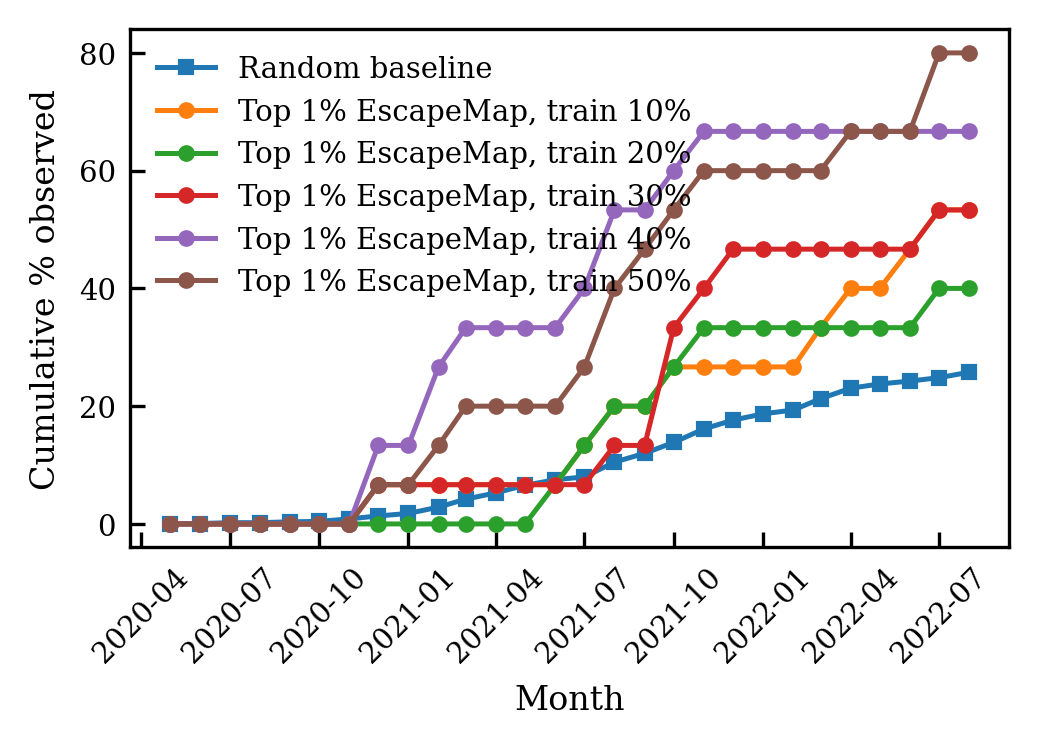

In [14]:
import pandas as pd, numpy as np, glob, re
import matplotlib as mpl, matplotlib.pyplot as plt

# --- config ---
th = 99  # top (100-th)% by EscapeMap within each subset file
tags = ["allab"]  # match what you used in run_fewshot()

# --- base data ---
df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df = df[(df['i'] >= 349) & (df['i'] <= 526)].copy()
df["first_seen"] = pd.to_datetime(df["first_seen"], format="%Y-%m", errors="coerce")
with_seen_all = df.dropna(subset=["first_seen"]).copy()
start, end = with_seen_all["first_seen"].min(), with_seen_all["first_seen"].max()
all_months = pd.date_range(start, end, freq="MS")

def cum_frac(seen_df, denom):
    out = []
    for m in all_months:
        appeared = (seen_df["first_seen"] <= m).sum()
        out.append({"date": m, "percentage": appeared / denom * 100})
    return pd.DataFrame(out)

# random baseline over all mutations in window
res_all = cum_frac(with_seen_all, len(df))

# --- style ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600, "axes.linewidth": 0.8,
    "lines.linewidth": 1.2, "lines.markersize": 3.0,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

# --- plot per antibody set tag ---
for tag in tags:
    files = sorted(glob.glob(f"scores_sigmoid_diff_{tag}_*.csv"),
                   key=lambda p: int(re.search(r"_(\d+)\.csv$", p).group(1)))
    if not files:
        print(f"No files for tag {tag}")
        continue

    fig, ax = plt.subplots(figsize=(3.375, 2.4))

    # add baseline
    ax.plot(res_all["date"], res_all["percentage"], marker="s", label="Random baseline")

    for fpath in files:
        # extract train fraction from filename
        frac_pct = int(re.search(r"_(\d+)\.csv$", fpath).group(1))
        f = pd.read_csv(fpath)
        col = "score" if "score" in f.columns else "scores"

        tmp = df.copy()
        tmp["esc"] = f[col].values  # aligned by row order
        thr_em = np.nanpercentile(tmp["esc"], th)
        top_em = tmp[tmp["esc"] >= thr_em].copy()
        with_seen_em = top_em.dropna(subset=["first_seen"]).copy()

        total_em = len(top_em)
        if total_em == 0 or with_seen_em.empty:
            print(f"{tag} {frac_pct}%: no top mutations or no dates")
            continue

        res_em = cum_frac(with_seen_em, total_em)
        ax.plot(res_em["date"], res_em["percentage"], marker="o",
                label=f"Top {100-th}% EscapeMap, train {frac_pct}%")

    ax.set_xlabel("Month")
    ax.set_ylabel("Cumulative % observed")
    ax.tick_params(direction="in", which="both", top=False, right=False)
    for lab in ax.get_xticklabels():
        lab.set_rotation(45)
    ax.legend(frameon=False, loc="best")
    fig.tight_layout(pad=0.5)
    plt.show()


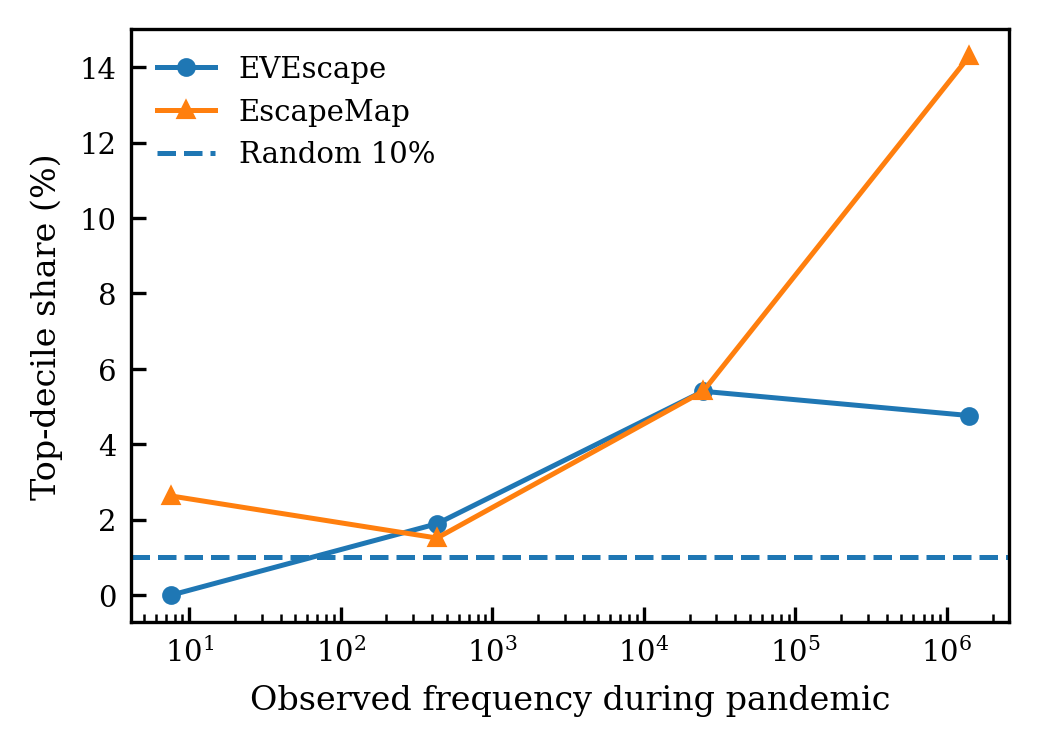

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load and restrict to RBD ---
df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df = df[(df['i'] >= 349) & (df['i'] <= 526)].copy()

# # Attach model scores (aligned by row order)
# df_em4 = pd.read_csv("scores_4ab_all.csv")
# df_em  = pd.read_csv("scores_all.csv")
col_em4 = "score" if "score" in df_em4.columns else "scores"
col_em  = "score" if "score" in df_em.columns  else "scores"
df["escapemap_4ab"] = df_em4[col_em4].values
df["escapemap"]     = df_em[col_em].values

# Parse first_seen
df["first_seen_dt"] = pd.to_datetime(df["first_seen"], format="%Y-%m", errors="coerce")

# Pandemic window
pandemic_start = pd.Timestamp("2020-01-01")
pandemic_end   = pd.Timestamp("2023-01-01")  # exclusive
obs = df[(df["first_seen_dt"] >= pandemic_start) & (df["first_seen_dt"] < pandemic_end)].copy()

# Top-decile thresholds computed on full RBD set
thr = {
    "EVEscape":      np.nanpercentile(df["evescape"], th),
    "EscapeMap":     np.nanpercentile(df["escapemap"], th),
    "EscapeMap_4Ab": np.nanpercentile(df["escapemap_4ab"], th),
}

# --- Frequency column "counts" and log-spaced bins ---
NB_EDGES = 5  # -> 19 bins
freq = pd.to_numeric(obs["counts"], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)  # keep zeros as 1 for binning

lo, hi = float(freq_clip.min()), float(freq_clip.max())
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")
edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

def share_top_decile(mask, col, threshold):
    if mask.sum() == 0:
        return np.nan
    sub = obs.loc[mask, col]
    return 100.0 * np.sum(sub >= threshold) / mask.sum()

# Compute percentages per bin
rows = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)

    rows.append({
        "freq_mid": midpoints[i],
        "n": int(bin_mask.sum()),
        "EVEscape":      share_top_decile(bin_mask, "evescape",      thr["EVEscape"]),
        "EscapeMap":     share_top_decile(bin_mask, "escapemap",     thr["EscapeMap"]),
        "EscapeMap_4Ab": share_top_decile(bin_mask, "escapemap_4ab", thr["EscapeMap_4Ab"]),
        "Random":        10.0
    })

plot_df = pd.DataFrame(rows).dropna(subset=["EVEscape","EscapeMap","EscapeMap_4Ab"], how="all")
import matplotlib as mpl
import matplotlib.pyplot as plt

# PRL-style rcParams
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 3.5,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))  # PRL single-column width

x = plot_df["freq_mid"].values
ax.plot(x, plot_df["EVEscape"],       marker="o", label="EVEscape")
ax.plot(x, plot_df["EscapeMap"],      marker="^", label="EscapeMap")
# ax.plot(x, plot_df["EscapeMap_4Ab"],  marker="v", label="EscapeMap (4 Ab)")
ax.axhline(100-th, linestyle="--", label="Random 10%")

ax.set_xscale("log")
ax.set_xlabel("Observed frequency during pandemic")
ax.set_ylabel("Top-decile share (%)")

# ticks inward, hide top/right ticks
ax.tick_params(direction="in", which="both", top=False, right=False)

ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()




AUCs -> EVEscape: 0.6318000213083315 EscapeMap: 0.68892099936075


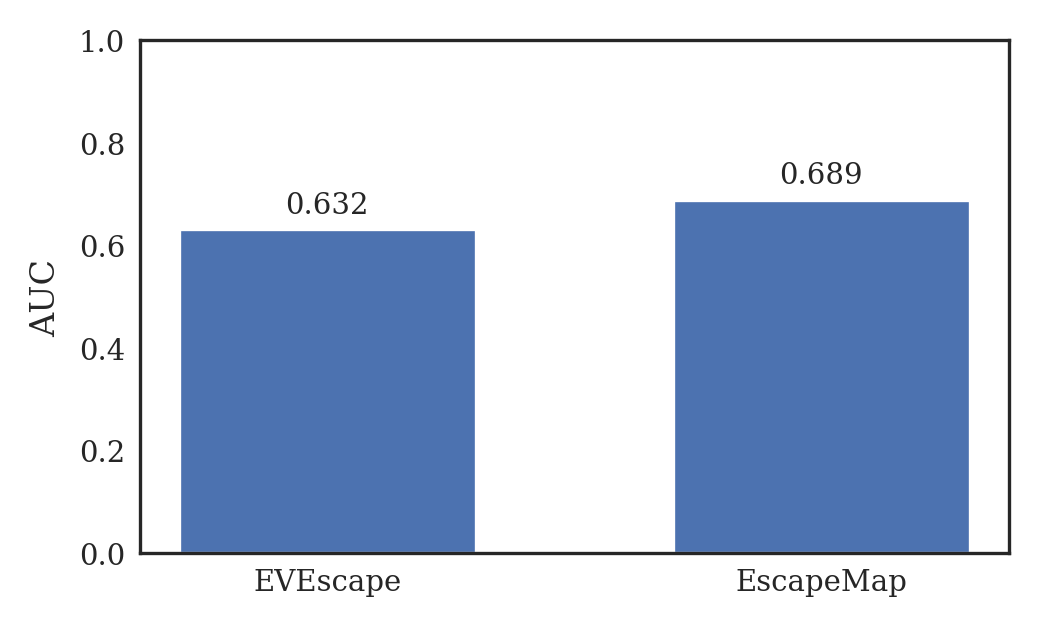

In [89]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- Load ---
df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df = df[(df['i'] >= 349) & (df['i'] <= 526)].copy()

df_em = pd.read_csv("scores_sigmoid_diff.csv")
col_em = "score" if "score" in df_em.columns else "scores"
df["escapemap"] = df_em[col_em].values

# --- Labels: y=1 if first_seen non-empty ---
df["first_seen_dt"] = pd.to_datetime(df["first_seen"], format="%Y-%m", errors="coerce")
y = (~df["first_seen_dt"].isna()).astype(int).values

# --- drop NaNs ---
mask = np.isfinite(df["evescape"].values) & np.isfinite(df["escapemap"].values)
y_m   = y[mask]
eve   = df.loc[mask, "evescape"].values
em    = df.loc[mask, "escapemap"].values

# --- AUCs ---
auc_eve = roc_auc_score(y_m, eve)
auc_em  = roc_auc_score(y_m, em)
print("AUCs -> EVEscape:", auc_eve, "EscapeMap:", auc_em)

# --- PRL-style plot ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "font.size": 8,
    "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

labels = ["EVEscape", "EscapeMap"]
values = [auc_eve, auc_em]

fig, ax = plt.subplots(figsize=(3.375, 2.0))
x = np.arange(len(values))
ax.bar(x, values, width=0.6)
ax.set_ylim(0.0, 1.0)
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel("AUC")
ax.tick_params(direction="in", which="both", top=False, right=False)

for xi, v in zip(x, values):
    ax.text(xi, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=7)

fig.tight_layout(pad=0.5)
plt.show()


# Scoring Vocs

In [76]:
VOCS=Proteins_utils.load_FASTA("../seq_data/sequences_vocs.fasta", drop_duplicates=False)
VOCS = VOCS[:,BEGIN:-END]
def extract_voc_names_from_fasta(fasta_path):
    """
    Extracts VOC names from a FASTA file.
    Assumes each entry starts with a '>' followed by the VOC name.
    """
    voc_names = []
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith('>'):
                voc_name = line[1:].strip()
                voc_names.append(voc_name)
    return voc_names

VOC_NAMES = extract_voc_names_from_fasta("../seq_data/sequences_vocs.fasta")#viruses

In [ ]:
import pandas as pd
import torch
from escape_map_torch import EscapeMapTorch
def load_escape_map_from_csv(csv_path, check_date,
                             rbm=RBM,
                             kd_vectors=KD_VECTORS,
                             ace2_vector=ACE2_KD_VECTOR,
                             default_conc=-18.0,
                             device=None,
                             dtype=torch.float64):
    df = pd.read_csv(csv_path)
    row = df.iloc[0]

    ab_names = list(kd_vectors.keys())
    raw_concs = []
    for ab in ab_names:
        colname = f"raw_c_{ab}"
        if colname in row and not pd.isna(row[colname]):
            raw_concs.append(row[colname])
        else:
            print(f"Warning: Antibody {ab} concentration not found in CSV; using default {default_conc}.")
            raw_concs.append(default_conc)

    model = EscapeMapTorch(
        rbm=rbm,
        kd_vectors=kd_vectors,
        ace2_vector=ace2_vector,
        raw_concentrations=raw_concs,
        raw_ace2=row["raw_ace2"],
        raw_beta=row["raw_beta"],
        total_beta=1.0,
        device=device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
        dtype=dtype,
    )
    return model

# Example usage:


In [78]:
# --- 2) VOC dates (appearance / first detected) ---
voc_dates = {
    "WT":    pd.Timestamp("2019-12-31"),  # first cases reported to WHO
    "Alpha": pd.Timestamp("2020-09-20"),  # earliest B.1.1.7 genomes
    "Beta":  pd.Timestamp("2020-10-01"),  # first detected Oct 2020 (B.1.351)
    "Gamma": pd.Timestamp("2021-01-06"),  # detected in travelers from Brazil to Japan
    "Delta": pd.Timestamp("2020-10-05"),  # first detected in India
    "BA.1":  pd.Timestamp("2021-11-24"),  # reported to WHO
    "BA.2":  pd.Timestamp("2021-11-15"),  # earliest BA.2 sample
    "BA.5":  pd.Timestamp("2022-02-25"),  # first detected sample, South Africa
    "BA.2.75": pd.Timestamp("2022-05-15"),  # first detected India (May 2022)
    "BQ.1.1": pd.Timestamp("2022-10-01"),  # circulation noted Oct 2022
    "XBB":   pd.Timestamp("2022-08-01"),  # first identified Aug 2022
    "JN.1":  pd.Timestamp("2023-08-25"),  # first detected Aug 2023
    "EG":    pd.Timestamp("2023-02-17"),  # EG.5 first reported Feb 2023
    # If your VOC_NAMES includes NB.1.8.1:
    "NB.1.8.1": pd.Timestamp("2025-01-22"),  # first sample collected Jan 22, 2025
}

# --- 3) Score VOC sequences ---
# assumes VOCS: np[int16] shape [K,L] and VOC_NAMES: list[str] length K
K = min(len(VOC_NAMES), VOCS.shape[0])
names = [str(x) for x in VOC_NAMES[:K]]

         voc      score       date
0         WT  51.988889 2019-12-31
1      Alpha  52.239747 2020-09-20
2       Beta  58.200969 2020-10-01
3      Delta  51.959559 2020-10-05
4      Gamma  56.638242 2021-01-06
5       BA.2  56.962287 2021-11-15
6       BA.1  57.064188 2021-11-24
7       BA.5  57.189099 2022-02-25
8    BA.2.75  56.717336 2022-05-15
9        XBB  57.013718 2022-08-01
10    BQ.1.1  57.335947 2022-10-01
11        EG  60.147775 2023-02-17
12      JN.1  59.737361 2023-08-25
13  NB.1.8.1  59.179369 2025-01-22


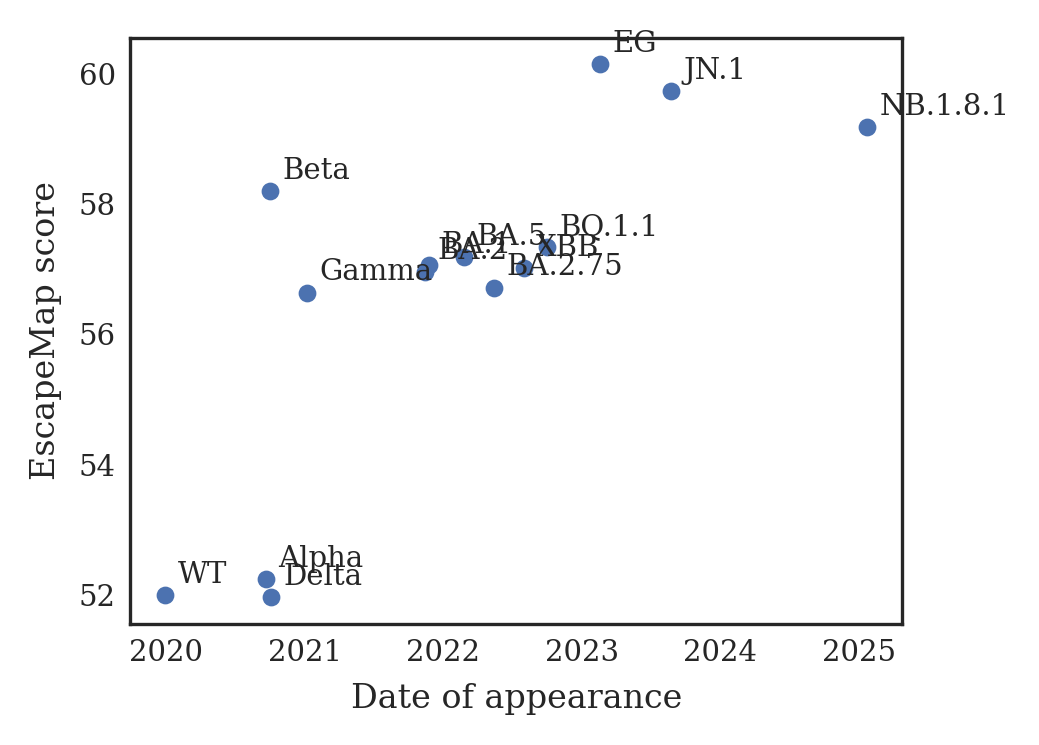

In [79]:

model = load_escape_map_from_csv("params_sigmoid_diff.csv", "2020-01")

def score_seq_batch(model, seqs_np):
    X = torch.as_tensor(VOCS)
    with torch.no_grad():
        s = -model(X)  # score = -energy
    return s.detach().cpu().numpy()

scores = score_seq_batch(model, VOCS[:K])

df_voc = pd.DataFrame({
    "voc": names,
    "score": scores,
    "date": [voc_dates.get(n) for n in names],
}).dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print(df_voc)

# --- 4) PRL-style plot: score vs appearance date ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))  # single-column width
ax.scatter(df_voc["date"], df_voc["score"], s=12)

# annotate
for _, r in df_voc.iterrows():
    ax.annotate(r["voc"], (r["date"], r["score"]),
                xytext=(3, 3), textcoords="offset points", fontsize=7)

ax.set_xlabel("Date of appearance")
ax.set_ylabel("EscapeMap score")
ax.tick_params(direction="in", which="both", top=False, right=False)
fig.tight_layout(pad=0.5)
fig.savefig("voc_scores_vs_date.pdf")
plt.show()

         voc      score       date
0         WT  51.544061 2019-12-31
1      Alpha  51.422125 2020-09-20
2       Beta  51.733843 2020-10-01
3      Delta  51.444303 2020-10-05
4      Gamma  51.763871 2021-01-06
5       BA.2  49.861968 2021-11-15
6       BA.1  50.822007 2021-11-24
7       BA.5  49.115285 2022-02-25
8    BA.2.75  49.351331 2022-05-15
9        XBB  49.566583 2022-08-01
10    BQ.1.1  49.307660 2022-10-01
11        EG  49.681517 2023-02-17
12      JN.1  49.177941 2023-08-25
13  NB.1.8.1  48.762722 2025-01-22


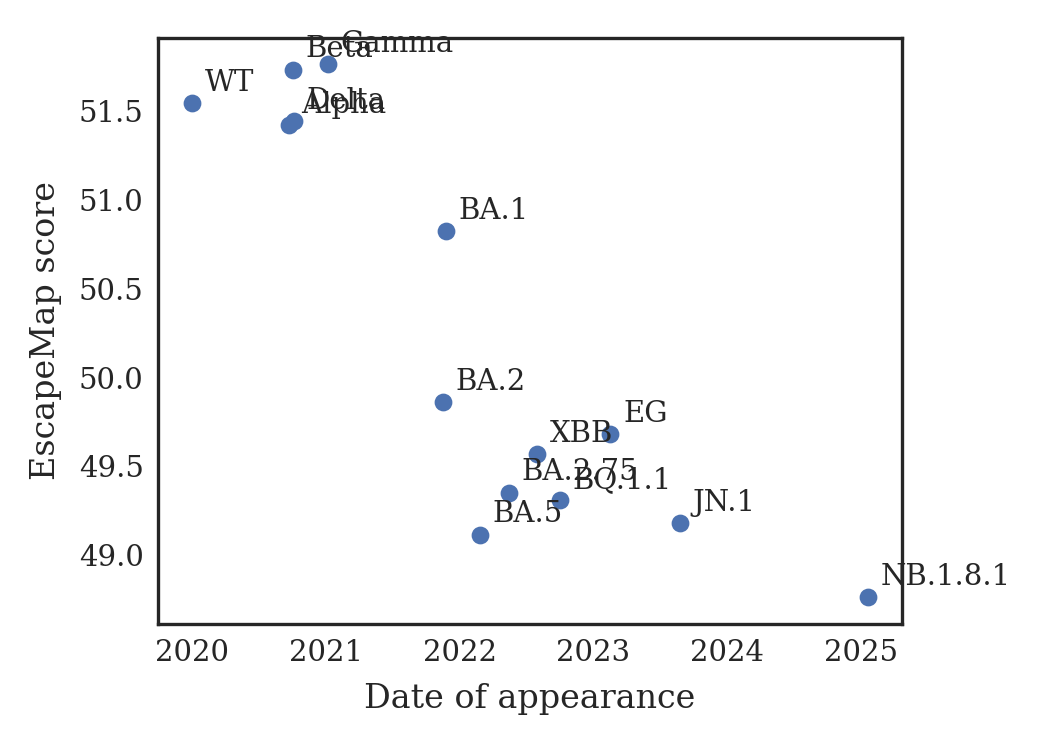

In [80]:

model = load_escape_map_from_csv("params_sigmoid_diff_4ab.csv", "2020-01")

def score_seq_batch(model, seqs_np):
    X = torch.as_tensor(VOCS)
    with torch.no_grad():
        s = -model(X)  # score = -energy
    return s.detach().cpu().numpy()

scores = score_seq_batch(model, VOCS[:K])

df_voc = pd.DataFrame({
    "voc": names,
    "score": scores,
    "date": [voc_dates.get(n) for n in names],
}).dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print(df_voc)

# --- 4) PRL-style plot: score vs appearance date ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))  # single-column width
ax.scatter(df_voc["date"], df_voc["score"], s=12)

# annotate
for _, r in df_voc.iterrows():
    ax.annotate(r["voc"], (r["date"], r["score"]),
                xytext=(3, 3), textcoords="offset points", fontsize=7)

ax.set_xlabel("Date of appearance")
ax.set_ylabel("EscapeMap score")
ax.tick_params(direction="in", which="both", top=False, right=False)
fig.tight_layout(pad=0.5)
fig.savefig("voc_scores_vs_date.pdf")
plt.show()